In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import sys
sys.path.insert(0, './')
from functions import *
import warnings
warnings.filterwarnings('ignore')

# Identify Vulnerable Tracts


In [230]:
filename = 'Data/Cleaned/postprocessed.pkl'
with open(filename, mode='rb') as f:
    df = pickle.load(f)

In [249]:
# TODO: figure out if dollar amounts in ACS are inflation adjusted or not

def find_vulnerable_tracts(df, year):
    
    # limit df to date provided
    df_yr = df[df.year==year]
    threshold_white = df_yr.percent_white.quantile(.7)
    threshold_income = df_yr.med_income.quantile(.7)
    
    # define eligible column if tract meets all criteria
    df_yr['vulnerable'] = np.where(
                            (df_yr.med_income <= threshold_income) &
                              (df_yr.percent_white <= threshold_white), 1, 0)
    vulnerable_tracts = df_yr[df_yr['vulnerable']==1]['full_tract'].unique()

    return df_yr


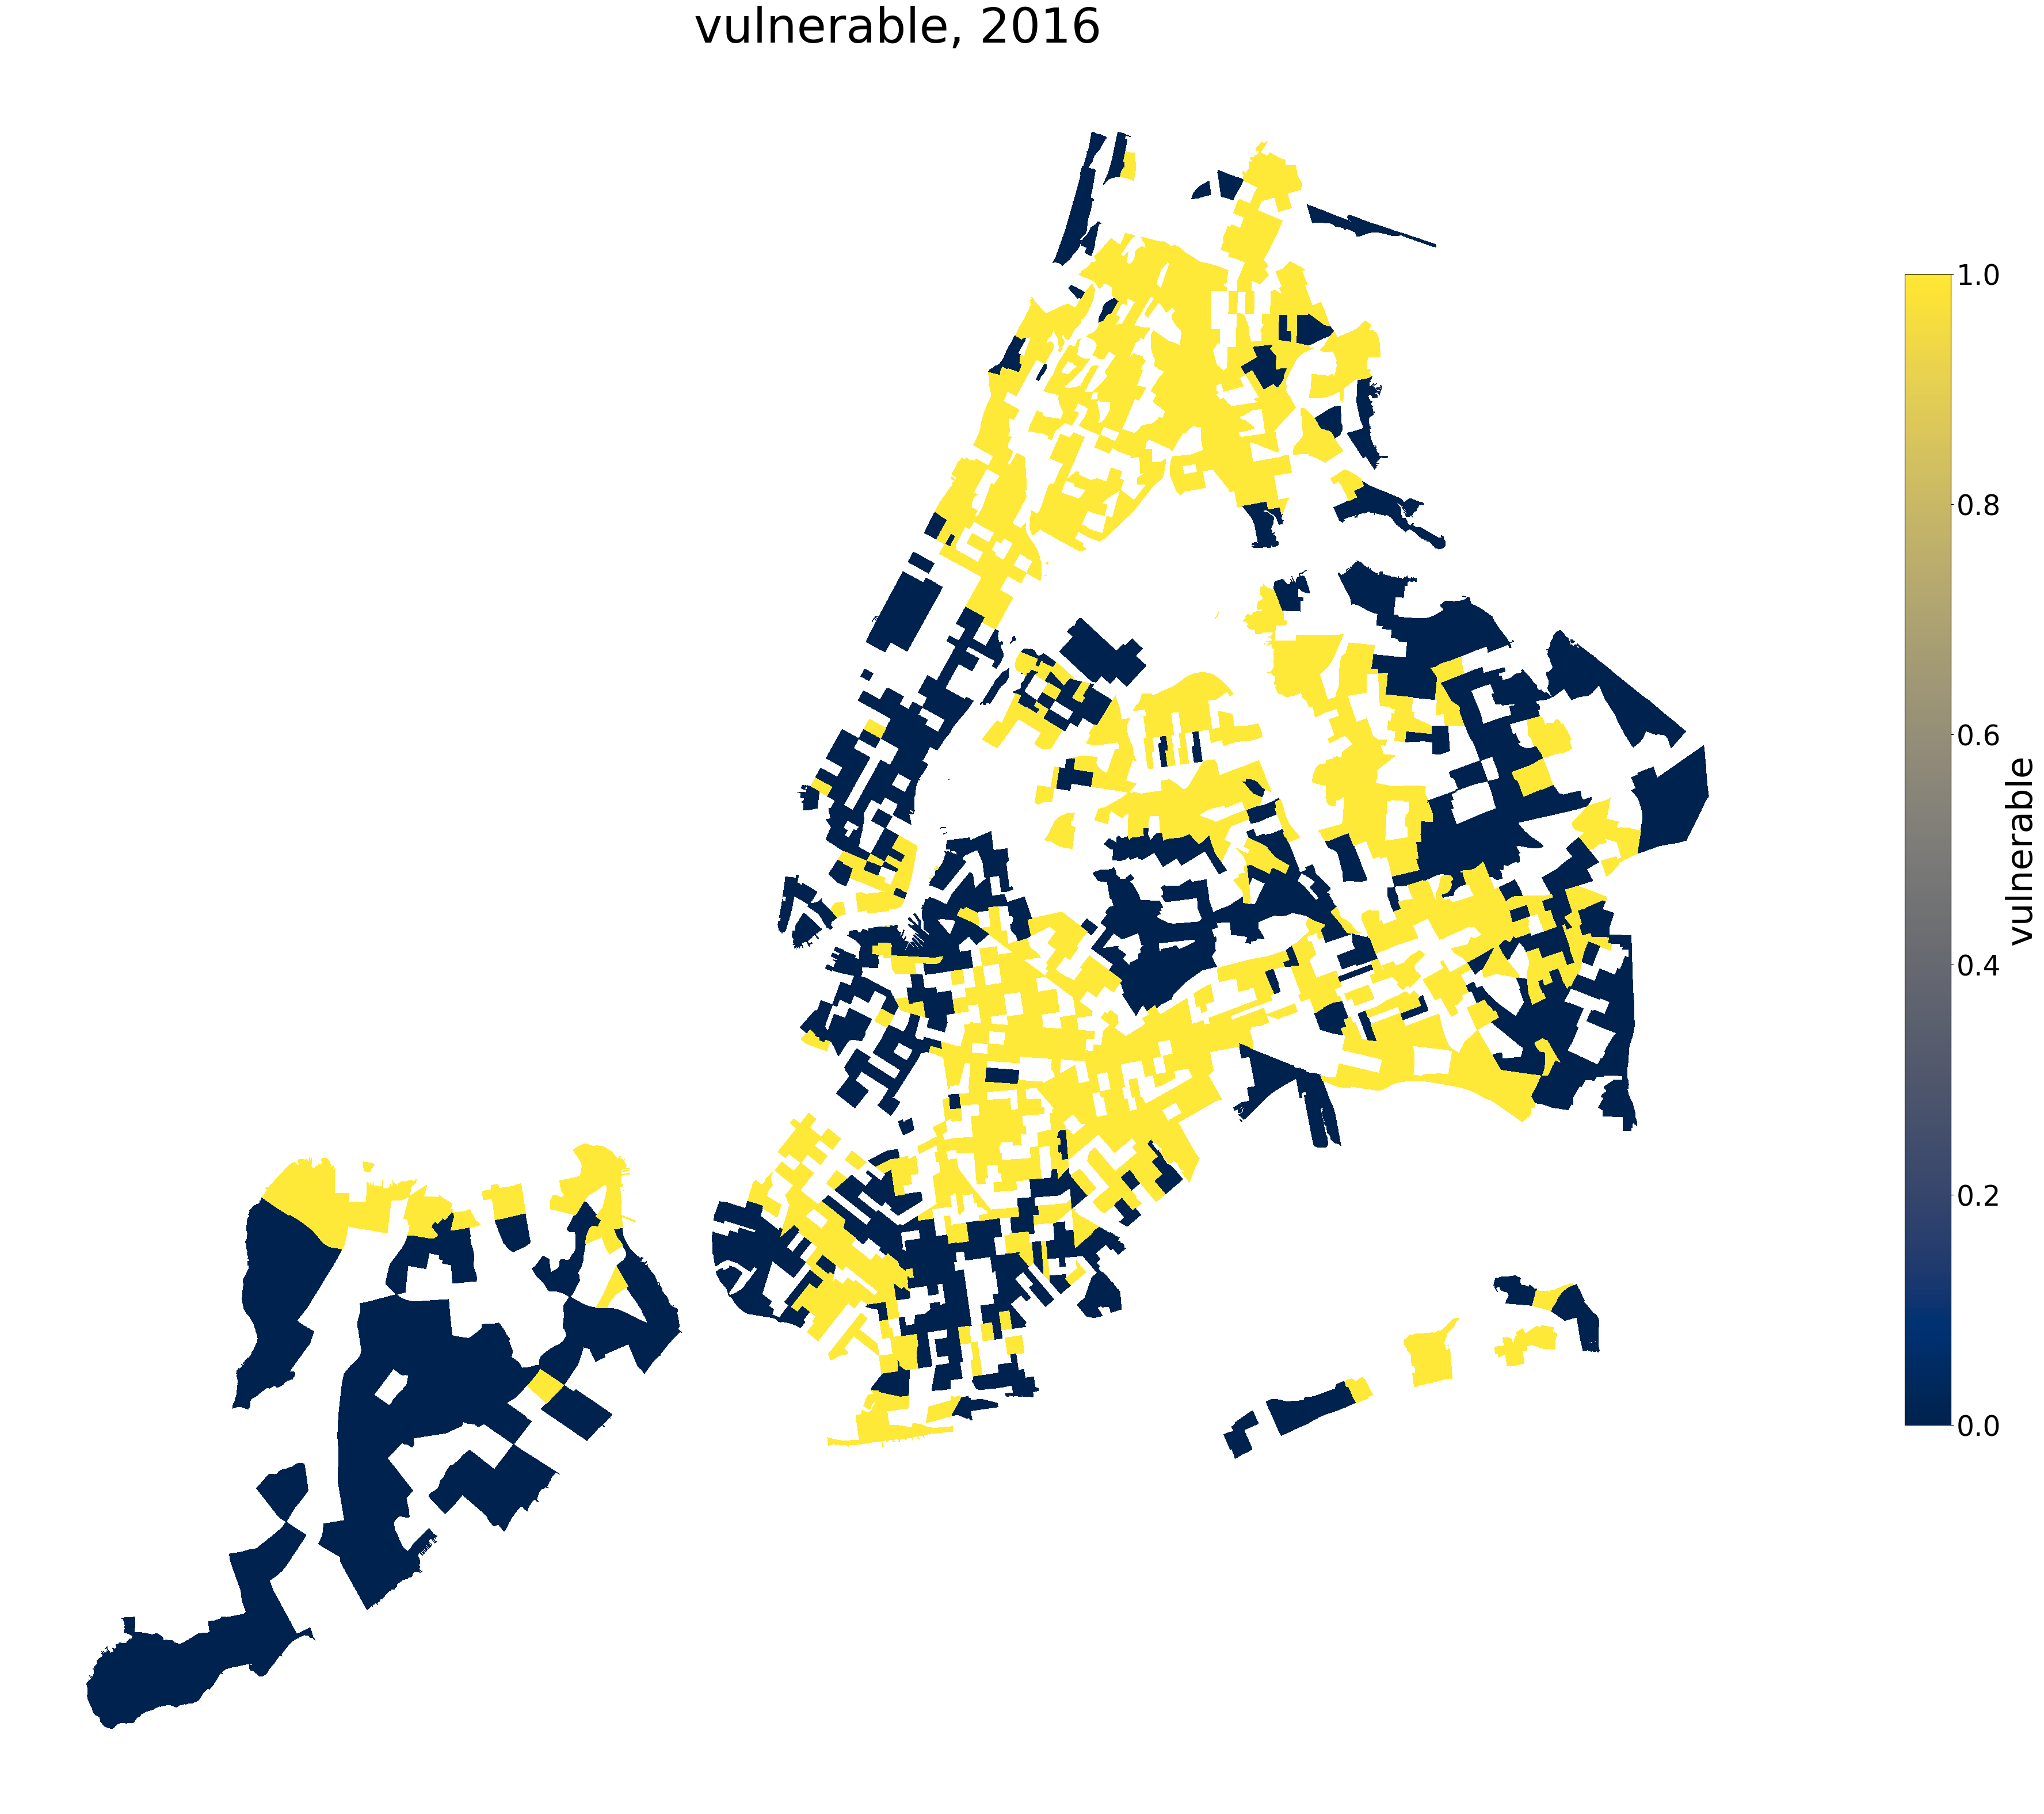

In [300]:
# Test out the function

df_16 = find_vulnerable_tracts(df, '2016')
choropleth(df_16, 'vulnerable', ['2016'], cmap='cividis')


# Generate Label
https://github.com/urban-displacement/displacement-typologies
- train on features 2012-2018 to predict gentrification status in 2022 (labels from 2022)
- train on features 2011-2017 to predict gentrification status in 2021 (labels from 2021)
- train on features 2010-2016 to predict gentrification status in 2020 (labels from 2020)
    - eligible tracts are taken from 2010?

- then use features 2016-2022 to predict gentrification status in 2026 (no labels)
    - eligible tracts are taken from 2016


### Determine if a Tract is Gentrified at Datestamp
We look at percent changes in decade prior to datestamp
- An increase in a tract's percent bachelor’s degrees was in the top third percentile of all tracts within a metro area.
- Increase in percent white is in top 3rd percentile
- The percentage increase in a tract’s inflation-adjusted median income was in the top third percentile of all tracts within a metro area.

In [291]:
def find_gentrified_tracts(df, pred_year):
    df = df[df.year.astype(int) >= pred_year-10]  # limit df to the decade prior
    
    # fill zeros with nan so we can calculate percent change
    df.replace(0, np.nan, inplace=True)
    
    # get average percent change over decade
    pct_chg = df.drop(['NAME','year','full_tract', 'vulnerable_2010'], axis=1).groupby('GEOID').agg(lambda x: x.pct_change().mean())
    pct_chg.dropna(how='all', inplace=True)
    pct_chg.fillna(0, inplace=True)

    # Set thresholds. consider it gentrifying if % change is greater than median for region

    # Median White
    threshold_white = pct_chg.percent_white.quantile(.5)

    # Median Bachelors
    threshold_bach = pct_chg.percent_bachelors.quantile(.5)

    # Median HH Median Income
    threshold_income = pct_chg.med_income.quantile(.5)

    # define gentrified column if tract meets all criteria
    pct_chg['gentrified_'+ str(pred_year)] = np.where((pct_chg.percent_white>=threshold_white)&
                                 (pct_chg.percent_bachelors>=threshold_bach)&
                                 (pct_chg.med_income>=threshold_income), 1, 0)  # 1 is gentrified, 0 is not
    
    return(pct_chg[['gentrified_'+ str(pred_year)]].reset_index())
    

In [292]:
# Identify Vulnerable Tracts

vul_tracts_df_10 = find_vulnerable_tracts(df, '2010')
vul_tracts_2010 = vul_tracts_df_10[vul_tracts_df_10['vulnerable']==1]['full_tract']
df['vulnerable_2010'] = np.where(df.full_tract.isin(vul_tracts_2010), 1,0)


In [293]:
# Identify Gentrified Tracts
gent_tracts_df_20 = find_gentrified_tracts(df, 2020)
gent_tracts_20 = gent_tracts_df_20[gent_tracts_df_20['gentrified_2020']==1]['GEOID']
df['gentrified_2020'] = np.where(df.GEOID.isin(gent_tracts_20), 1,0)


In [294]:
# Create label based on vulnerable and gentrified tracts
df['label'] = np.select([df['gentrified_2020']==1, ((df['gentrified_2020']==0) & (df['vulnerable_2010']==0)), ((df['gentrified_2020']==0) & (df['vulnerable_2010']==1))],
                      [2,0,1],
                      -1)

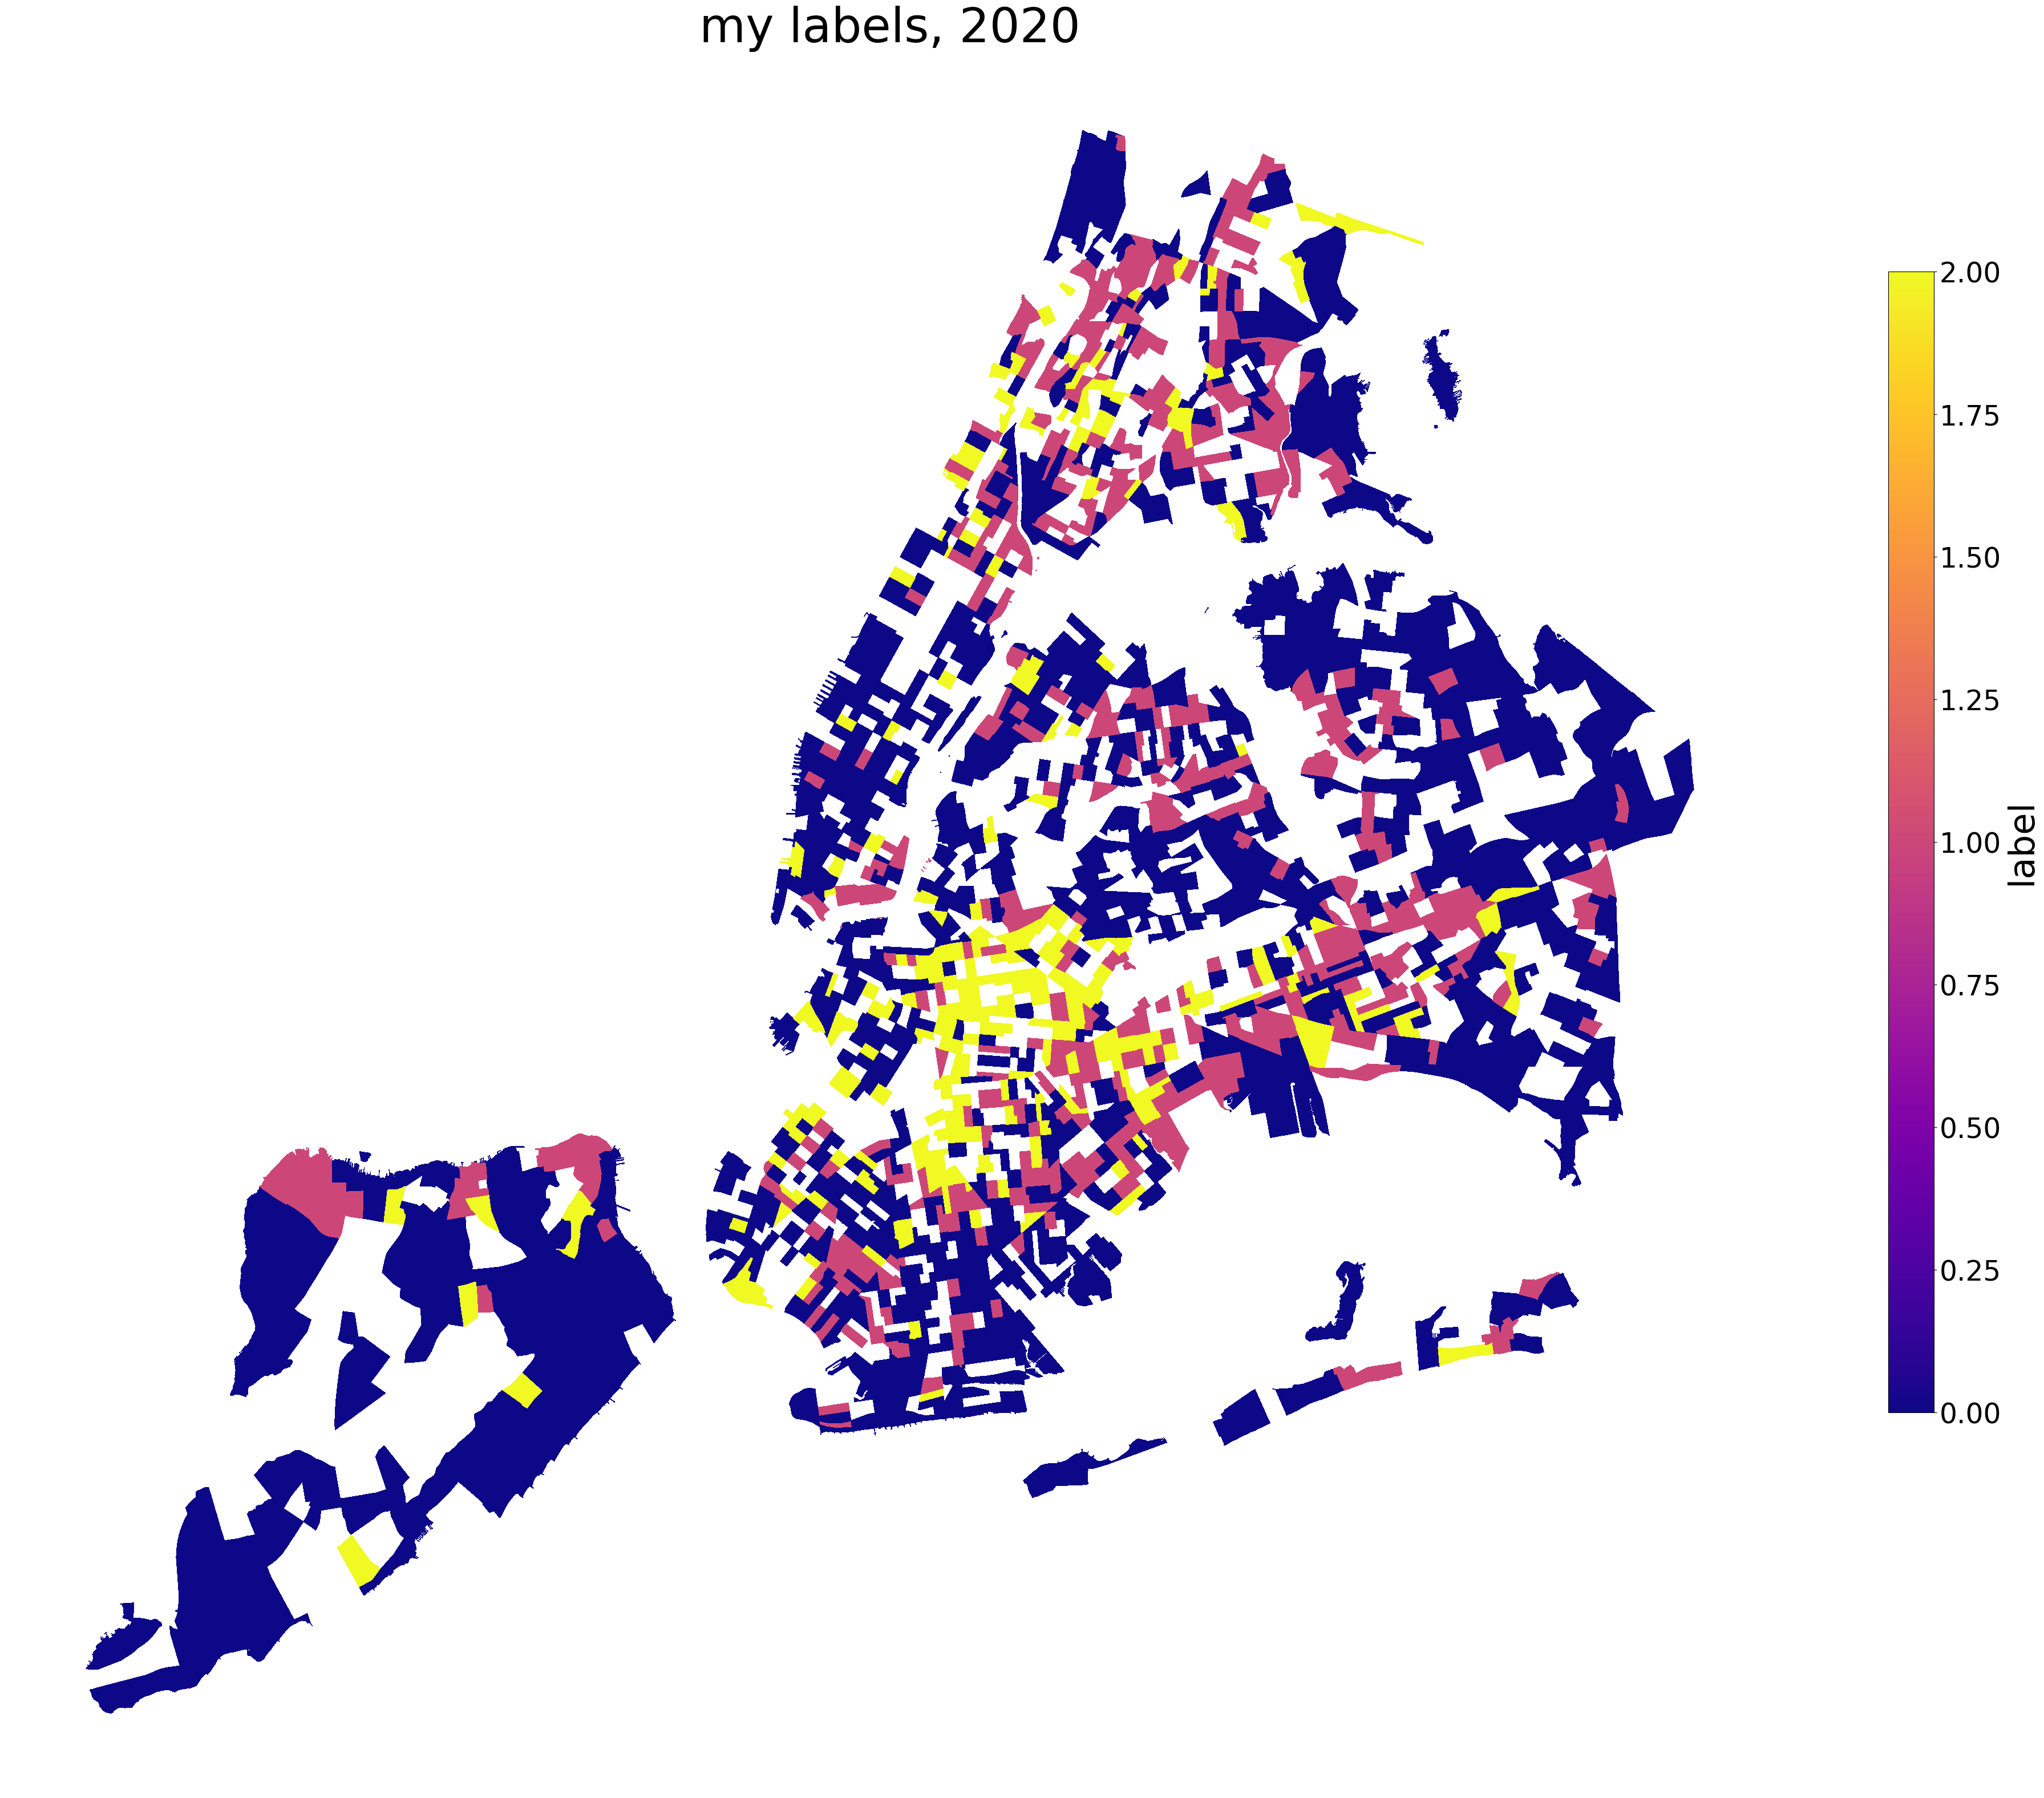

In [295]:
choropleth(df, 'label', ['2020'], cmap='plasma', title='my labels')

## Corroborate labels with UDP 2016

In [186]:
labels_16 = pd.read_excel("Data/Raw/udp_labels_2016.xlsx")
df_16 = find_vulnerable_tracts(df, '2016')

In [204]:

labels_16['udp_labels'] = np.select([labels_16['Type_1.19'].isin(['LI - At Risk of Gentrification',
                                   'LI - Ongoing Gentrification']),
                                        labels_16['Type_1.19'].isin(['LI - Ongoing Displacement of Low-Income Households',
       'LI - Not Losing Low-Income Households']),
                                        labels_16['Type_1.19'].isin(['MHI - Advanced Gentrification',
       'MHI - Ongoing Exclusion', 'MHI - Stable Exclusion',
       'Missing Data', 'VHI - Super Gentrification or Exclusion'])],
                                        [2,1,0], 
                                        -1)
labels_16['geoid'] = labels_16['geoid'].astype(str)
udp_df = df_16.merge(labels_16, left_on='GEOID', right_on='geoid')


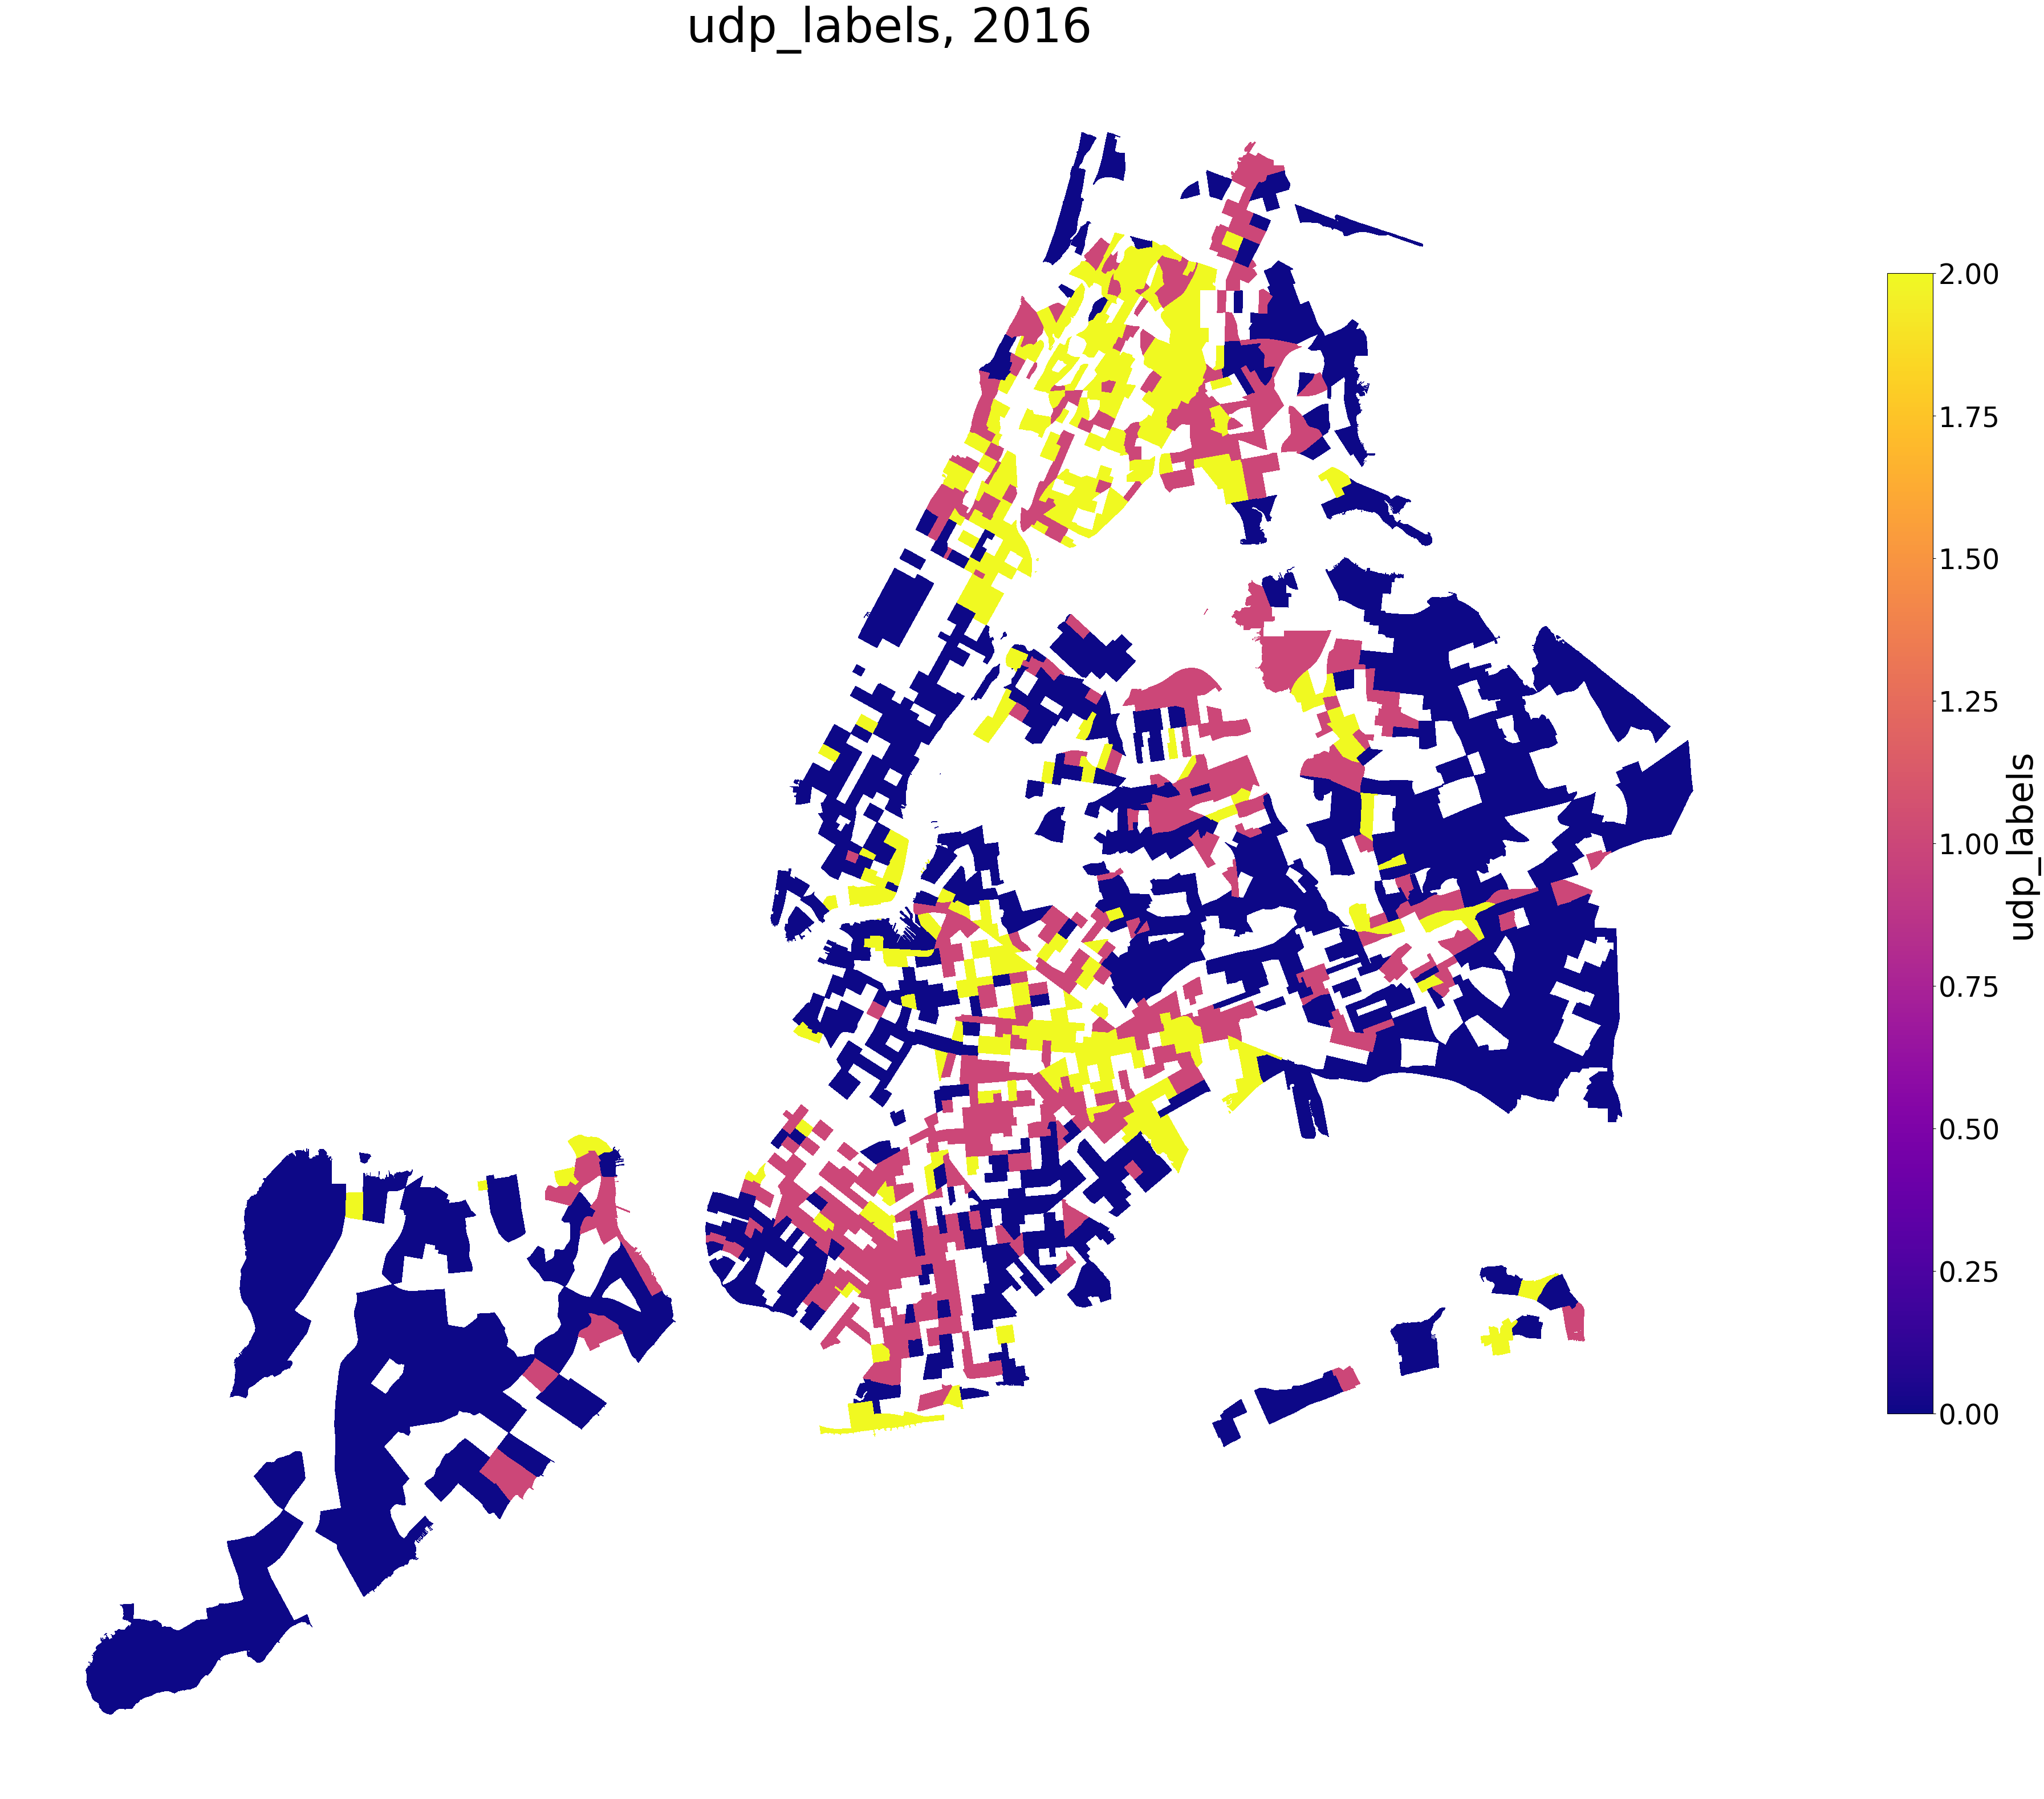

In [205]:
choropleth(udp_df, 'udp_labels', ['2016'], cmap='plasma')